<a href="https://colab.research.google.com/github/pquimerch08/tp1_collab_pol_quimerch/blob/main/tp2_pol_quimerch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2

## 1. Prise en main: Préparation des données

In [119]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, round, split, explode, regexp_replace, when, ceil, col, to_date
import missingno as msno
import matplotlib.pyplot as plt
from pyspark.ml.feature import Imputer

#### Initialiser la session Spark

In [120]:
spark = SparkSession.builder.appName("MoviesData").getOrCreate()

#### Charger le fichier CSV dans un DataFrame

In [121]:
file_path = "netflix1.csv"
df = spark.read.option("header", "true").csv(file_path)

In [122]:
df.show(10)

+-------+-------+--------------------+-------------------+--------------+----------+------------+------+---------+--------------------+
|show_id|   type|               title|           director|       country|date_added|release_year|rating| duration|           listed_in|
+-------+-------+--------------------+-------------------+--------------+----------+------------+------+---------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|    Kirsten Johnson| United States| 9/25/2021|        2020| PG-13|   90 min|       Documentaries|
|     s3|TV Show|           Ganglands|    Julien Leclercq|        France| 9/24/2021|        2021| TV-MA| 1 Season|Crime TV Shows, I...|
|     s6|TV Show|       Midnight Mass|      Mike Flanagan| United States| 9/24/2021|        2021| TV-MA| 1 Season|TV Dramas, TV Hor...|
|    s14|  Movie|Confessions of an...|      Bruno Garotti|        Brazil| 9/22/2021|        2021| TV-PG|   91 min|Children & Family...|
|     s8|  Movie|             Sankofa|       Hai

#### Supprimer les lignes contenant des valeurs nulles


In [123]:
valeurs = ["Not Given", "N/A", "Unknown", ""]

df_clean = df.select(
    [when(col(c).isin(valeurs), None).otherwise(col(c)).alias(c) for c in df.columns]
)

# Afficher les résultats
df_clean.show(truncate=False)

+-------+-------+--------------------------------+-------------------------------+--------------+----------+------------+------+---------+-------------------------------------------------------------+
|show_id|type   |title                           |director                       |country       |date_added|release_year|rating|duration |listed_in                                                    |
+-------+-------+--------------------------------+-------------------------------+--------------+----------+------------+------+---------+-------------------------------------------------------------+
|s1     |Movie  |Dick Johnson Is Dead            |Kirsten Johnson                |United States |9/25/2021 |2020        |PG-13 |90 min   |Documentaries                                                |
|s3     |TV Show|Ganglands                       |Julien Leclercq                |France        |9/24/2021 |2021        |TV-MA |1 Season |Crime TV Shows, International TV Shows, TV Action & Advent

## 2. Visualisation des données manquantes

#### Convertir temporairement le DataFrame PySpark en DataFrame *Pandas*

In [124]:
# Fraction approximative pour obtenir un échantillon de 1000 lignes
fraction = 1000 / df_clean.count()

#Réduire le tableau à 1000 lignes pour limiter l'utilisation de la mémoire
df_sample = df_clean.sample(withReplacement=False, fraction=fraction, seed=42)
df_sample_limited = df_sample.limit(1000)
pandas_df = df_sample_limited.toPandas()

# Afficher le nombre de ligne total et le nombre de colonnes
print(f"Nombre de lignes : {df_clean.count()}, Nombre de colonnes : {len(df_clean.columns)}")

Nombre de lignes : 8791, Nombre de colonnes : 10


#### Utiliser Missingno (msno.bar()) pour visualiser la répartition desvaleurs manquantes.

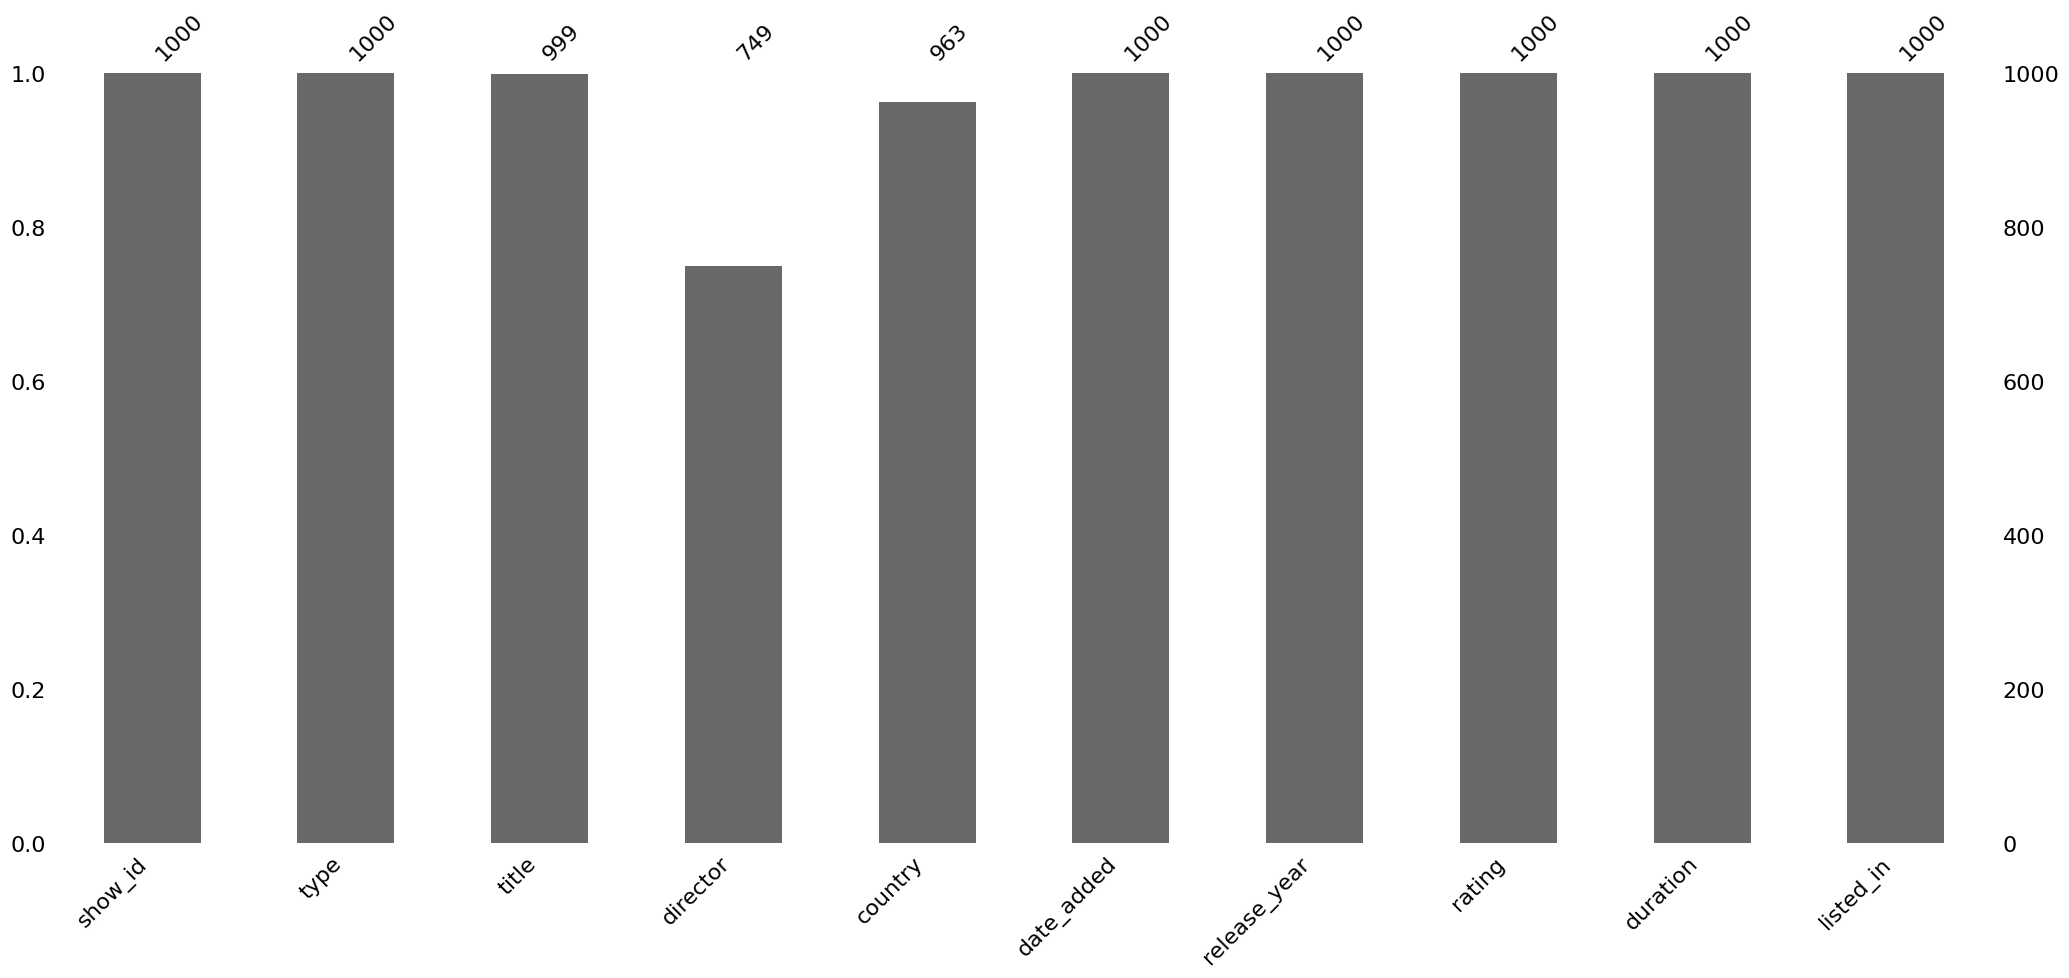

In [125]:
msno.bar(pandas_df)

# Afficher le graphique
plt.show()

Le graphique bar chart affiché par msno.bar() montre pour chaque colonne :

*   La hauteur de la barre noire représente le nombre total de valeurs présentes dans cette colonne.
*   L’espace vide au-dessus de la barre indique le nombre de valeurs manquantes.
*   Si une colonne est entièrement remplie, la barre sera complètement noire.
*   Si une colonne est partiellement remplie, la barre sera plus courte.

In [126]:
# Calculer le pourcentage de valeurs manquantes
missing_percentage = pandas_df.isnull().mean() * 100

# Trier par pourcentage décroissant
missing_percentage = missing_percentage.sort_values(ascending=False)

# Afficher les colonnes avec des valeurs manquantes
print(missing_percentage)

director        25.1
country          3.7
title            0.1
show_id          0.0
type             0.0
date_added       0.0
release_year     0.0
rating           0.0
duration         0.0
listed_in        0.0
dtype: float64


## 3. Nettoyage et réinspection


#### Appliquer un filtre pour supprimer les lignes manquantes dans certaines colonnes clés

In [127]:
# Supprimer les lignes où 'director' ou 'country' contient des valeurs nulles
pandas_df_cleaned = pandas_df.dropna(subset=["director", "country"])

#### Générer un nouveau graphique Missingno sur le DataFrame pour comparer avec le graphique précédent

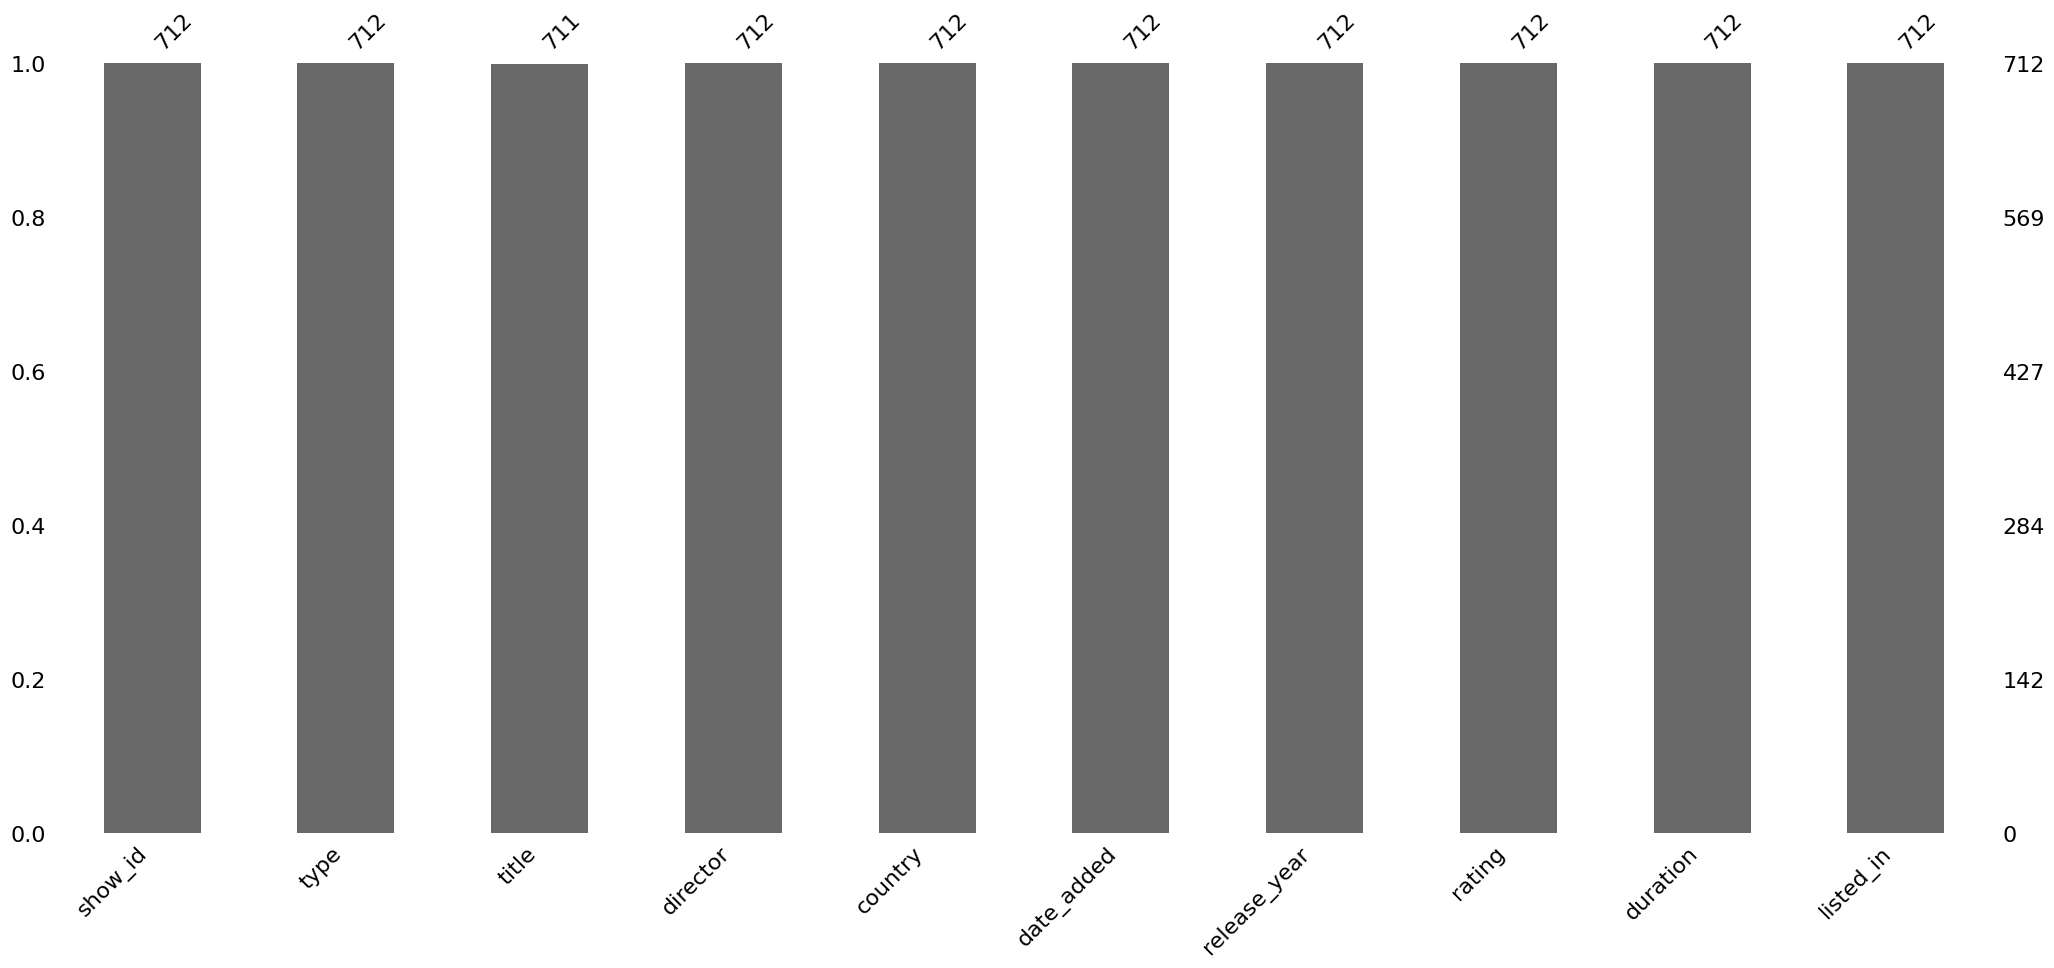

In [128]:
# Visualiser les données manquantes
msno.bar(pandas_df_cleaned)

# Afficher le graphique
plt.show()

On constate donc qu'une fois les lignes avec des valeurs 'null' dans la colonne director et la colonne country supprimée, la qualité du DataFrame s'est nettement améliorée.

In [129]:
# Calculer le pourcentage de valeurs manquantes
missing_percentage = pandas_df_cleaned.isnull().mean() * 100

# Trier par pourcentage décroissant
missing_percentage = missing_percentage.sort_values(ascending=False)

# Afficher les colonnes avec des valeurs manquantes
print(missing_percentage)

title           0.140449
show_id         0.000000
type            0.000000
director        0.000000
country         0.000000
date_added      0.000000
release_year    0.000000
rating          0.000000
duration        0.000000
listed_in       0.000000
dtype: float64


Ici nous pouvons constater que le pourcentage de valeurs manquantes à énormément réduit

## 4. Analyses complémentaires

#### Réfléchir à d’autres approches de traitement des données manquantes

###### Imputation conditionnelle

In [130]:
critical_columns = ['director', 'country']
pandas_df = pandas_df.dropna(subset=critical_columns)  # Suppression ciblée des lignes critiques


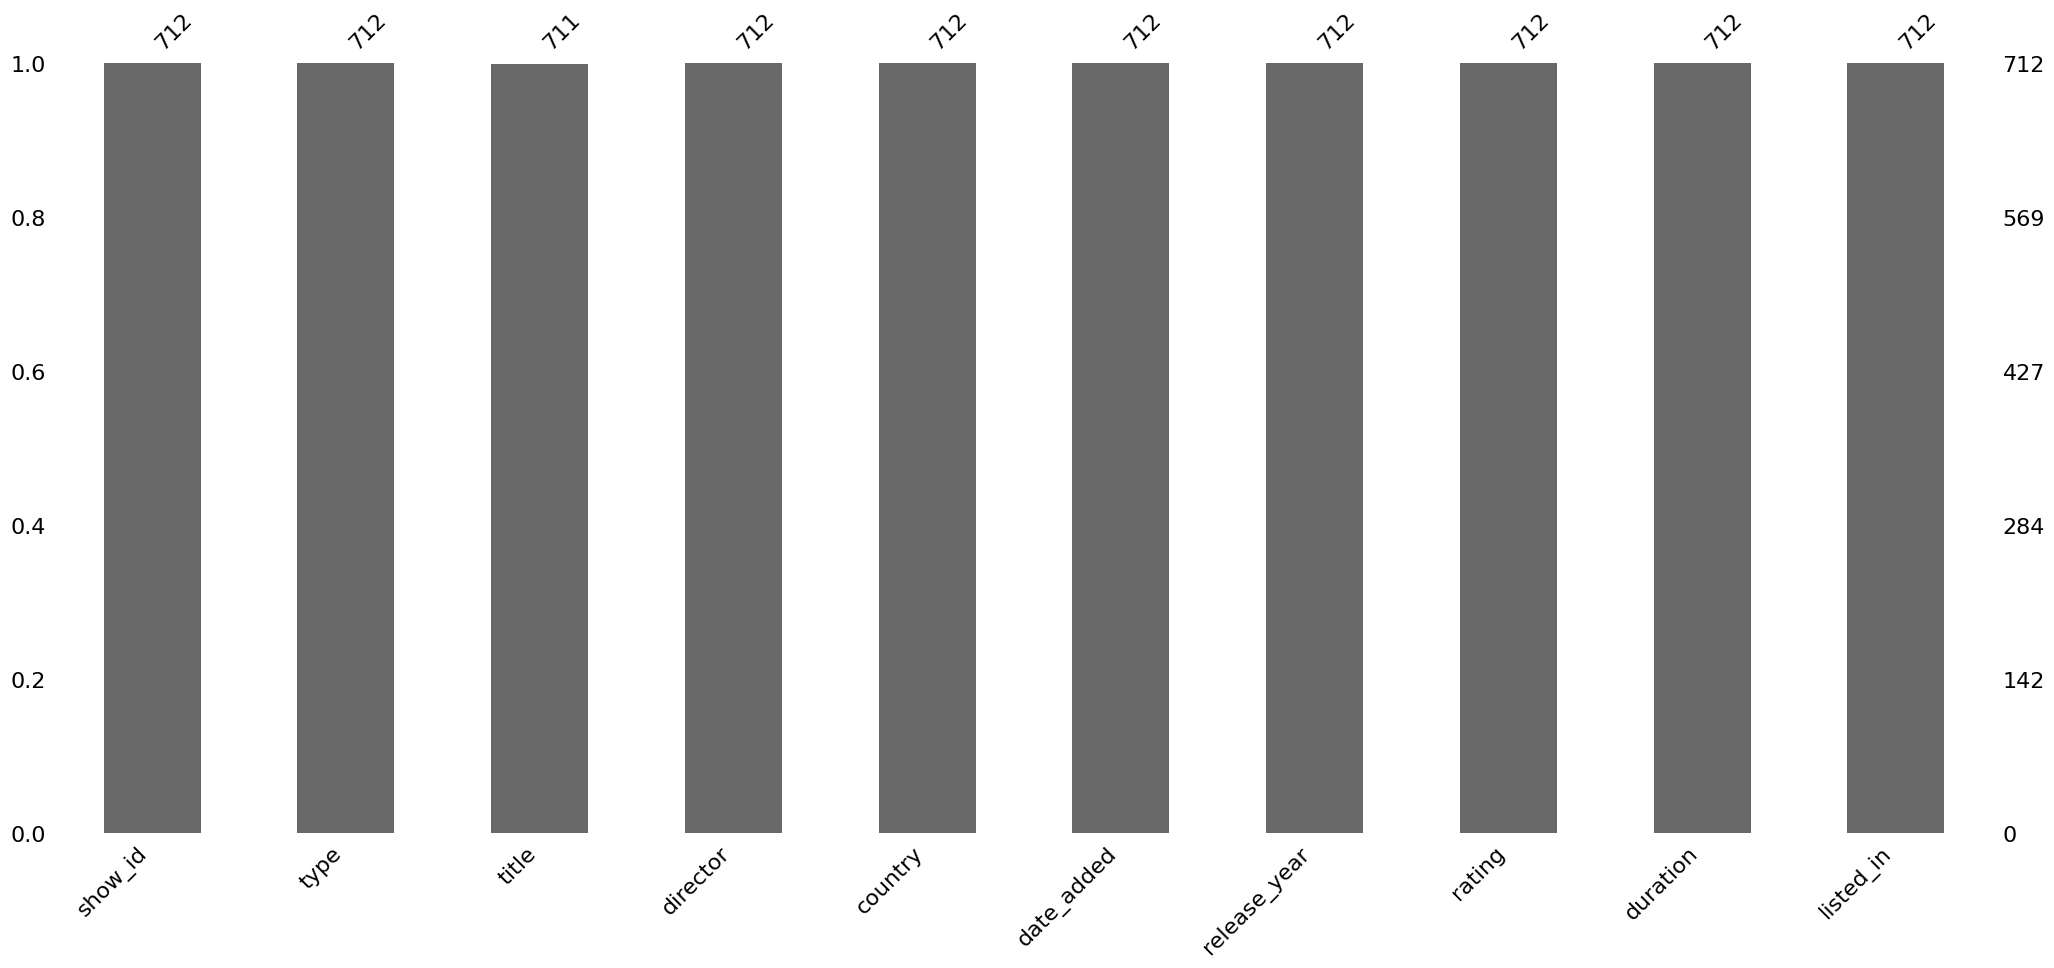

In [131]:
pandas_df['country'] = pandas_df.groupby('listed_in')['country'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown Country')
)
pandas_df['director'] = pandas_df['director'].fillna('Unknown Director')

msno.bar(pandas_df)
plt.show()

#### Intégrer ce nettoyage à la suite des transformations du TP1

In [132]:
from pyspark.sql import functions as F

# Compter le nombre d'occurrences de chaque type
df_type_count = df.groupBy("type").count()
total_count = df.count()

# Calculer le pourcentage de chaque type
df_percentage = df_type_count.withColumn("percentage", (F.col("count") / total_count) * 100)
df_percentage.show()

+-------------+-----+--------------------+
|         type|count|          percentage|
+-------------+-----+--------------------+
|      TV Show| 2664|   30.30371971334319|
|        Movie| 6126|   69.68490501649414|
|William Wyler|    1|0.011375270162666363|
+-------------+-----+--------------------+



On peut remarquer qu'une ligne se nomme 'William Wyler' qui est un nom de réalisateur et non un type de projection

In [149]:
# Supprimer la ligne contenant 'William Wyler'
df_cleaned = df_clean.filter(df_clean['type'] != 'William Wyler')


+-------+-------+--------------------+--------------------+--------------+----------+------------+------+---------+--------------------+
|show_id|   type|               title|            director|       country|date_added|release_year|rating| duration|           listed_in|
+-------+-------+--------------------+--------------------+--------------+----------+------------+------+---------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson| United States|      NULL|        2020| PG-13|   90 min|       Documentaries|
|     s3|TV Show|           Ganglands|     Julien Leclercq|        France|      NULL|        2021| TV-MA| 1 Season|Crime TV Shows, I...|
|     s6|TV Show|       Midnight Mass|       Mike Flanagan| United States|      NULL|        2021| TV-MA| 1 Season|TV Dramas, TV Hor...|
|    s14|  Movie|Confessions of an...|       Bruno Garotti|        Brazil|      NULL|        2021| TV-PG|   91 min|Children & Family...|
|     s8|  Movie|             Sankofa|   

In [143]:
# Trier les dates en ordre croissant
df_sorted = df_spark.orderBy("date_added", ascending=True)
df_sorted.show()

+-------+-------+--------------------+--------------------+--------------+----------+------------+------+--------+--------------------+
|show_id|   type|               title|            director|       country|date_added|release_year|rating|duration|           listed_in|
+-------+-------+--------------------+--------------------+--------------+----------+------------+------+--------+--------------------+
|  s5939|  Movie|Aziz Ansari: Buri...|Will Lovelace, Dy...| United States|2013-11-01|        2013| TV-MA|  80 min|     Stand-Up Comedy|
|  s5937|  Movie|   Shrek the Musical|         Jason Moore| United States|2013-12-29|        2013|  TV-G| 130 min|Children & Family...|
|  s5925|  Movie|Chelsea Peretti: ...|         Lance Bangs| United States|2014-11-14|        2014| TV-MA|  75 min|     Stand-Up Comedy|
|  s7723|  Movie|Pee-wee's Playhou...|Paul Reubens, Way...| United States|2014-12-18|        1988| TV-PG|  48 min|              Movies|
|  s8097|  Movie|Stop at Nothing: ...|         A